In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["SERPAPI_API_KEY"] = os.getenv("SERPAPI_API_KEY")
alphavantage_api_key = os.getenv("ALPHA_VANTAGE_API_KEY")


In [2]:
from typing_extensions import TypedDict, Annotated

from langchain.chat_models import init_chat_model
from langchain.tools import Tool
from langchain_community.tools import tool
from langchain_core.messages import HumanMessage, AnyMessage

from langchain_community.utilities import SerpAPIWrapper
from langchain_community.utilities.alpha_vantage import AlphaVantageAPIWrapper
from langchain_experimental.tools.python.tool import PythonREPLTool 

from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages

from IPython.display import Image, display

In [3]:
llm = init_chat_model("gpt-4.1", temperature=0.7)

In [4]:
serpapi_tool = Tool(
    name="serpapi",
    description="Optimizes e-commerce purchase flows by analyzing real-time search engine results for product visibility, competitor pricing, and market trends, improving conversion rates.",
    func=SerpAPIWrapper().run,
)

alpha_vantage_api = AlphaVantageAPIWrapper(alphavantage_api_key=alphavantage_api_key)

@tool
def currency_tool(from_currency: str, to_currency: str) -> str:
    """Get exchange rate between two currencies."""
    return alpha_vantage_api.run(from_currency=from_currency, to_currency=to_currency)

repl_tool = PythonREPLTool()


In [5]:
# Create the list of properly wrapped Tool instances
tools = [serpapi_tool, currency_tool, repl_tool]

In [6]:
react_prompt = """
You are an AI assistant specialized in helping users find the best value when shopping online.

You can perform the following actions/tools:
- Use a **Product Search Tool** to find current prices, sellers, and offers for the product specified by the user.
- Use a **Review Aggregator Tool** to gather and summarize average user ratings or top reviews.
- Use a **Currency Converter Tool** to convert prices between currencies.
- Use the **Python REPL tool** to perform any calculations, such as total cost, percent savings, or final price with tax.

For each request:
- ALWAYS break the user’s question into clear subtasks, think out loud about each step, and choose the right tool for each part.
- If a step fails, try an alternative approach or suggest other options.

When you have completed all necessary tool use and gathered all information:
- ALWAYS output a final message that **begins with the phrase "Final answer:"** (e.g., `Final answer: The Kindle Paperwhite is cheapest at ...`).
- Clearly summarize product(s) found with price, currency conversion, and seller.
- State the average user rating (if available).
- Calculate the total estimated cost in the user's preferred currency, including conversion and any important fees.
- Give brief advice or next steps, for example: "You may want to check warranty terms from overseas sellers."

**Do not give your final answer until all required tools have been used. Your very last message must always begin with "Final answer:".**
"""


In [7]:
class State(TypedDict):
    messages : Annotated[list[AnyMessage], add_messages]

In [8]:
def reasoning_node(state: State):
    # LLM with bound tools to enable tool-calling
    llm_with_tools = llm.bind_tools(tools)
    messages = [{"role": "system", "content": react_prompt}] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": state["messages"] + [response]}

In [9]:
tool_node = ToolNode(tools = tools)

In [10]:
def should_continue(state: State):
    last_message = state["messages"][-1]
    if hasattr(last_message, "content") and "final answer:" in last_message.content.lower():
        return "end"
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "continue"
    if len(state["messages"]) > 20:
        return "end"
    # Otherwise, no tool_calls, not a final answer, so end gracefully
    return "end"

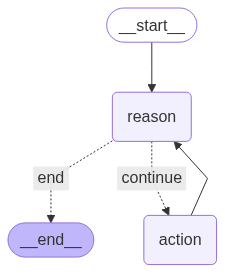

In [11]:
builder = StateGraph(State)
builder.add_node("reason", reasoning_node)
builder.add_node("action", tool_node)
builder.set_entry_point("reason")
builder.add_conditional_edges(
    "reason",
    should_continue,
    {
        "continue": "action",
        "end": END,
    }
)
builder.add_edge("action", "reason")
ecommerce_agent = builder.compile()

display(Image(ecommerce_agent.get_graph().draw_mermaid_png()))

In [12]:
query = ("""
         Find me the best price for ‘Sony WH-1000XM5’ headphones online. 
         What’s the average user rating, and if I buy from the US for €350, 
         how much is the import tax to Germany
         """)

state = {"messages": [HumanMessage(content=query)]}
result = ecommerce_agent.invoke(state)

print(result["messages"][-1].content)


Python REPL can execute arbitrary code. Use with caution.


Here's what I found:

1. Best Price: The lowest recent online price for the Sony WH-1000XM5 headphones is around $279.99–$296.00 USD (approx. €260–€275), but your specified purchase is €350 from the US.
2. Average User Rating: The Sony WH-1000XM5 headphones have an average user rating of about 4.3 out of 5 stars, based on over 11,000 reviews. Reviews highlight excellent noise cancellation, great battery life (~27 hours), and strong sound/call quality.
3. Import Tax to Germany: For a purchase price of €350, the 19% German VAT (import tax) would be €66.50, making the total estimated cost €416.50. There are no additional customs duties for headphones, just the VAT.

Final answer: The Sony WH-1000XM5 headphones are available online for as low as $279.99–$296.00 USD (~€260–€275), but if you buy from the US for €350, you’ll pay approximately €66.50 in German VAT, totaling €416.50. The headphones have an average user rating of 4.3/5. Double-check warranty coverage for international purchases,

In [13]:
query = ("Find me the cheapest place to buy the Kindle Paperwhite in USD and INR.")

state = {"messages": [HumanMessage(content=query)]}
result = ecommerce_agent.invoke(state)

print(result["messages"][-1].content)


Here’s the full summary of findings:

1. Cheapest Kindle Paperwhite (latest model) prices:
   - Amazon US: $139.99 USD (brand new, sold and fulfilled by Amazon)
   - Amazon India: ₹16,999 INR (brand new, sold and fulfilled by Amazon.in)
   - Flipkart: ₹16,999 INR (brand new, matches Amazon India)

2. Currency conversion:
   - $139.99 USD ≈ ₹12,277 INR (using the current exchange rate 1 USD ≈ 87.7 INR)
   - The US price is cheaper by approximately ₹4,700 INR compared to the Indian price.

3. Average user rating:
   - Kindle Paperwhite typically has an excellent average rating of around 4.5 out of 5 stars on major sites like Amazon.

4. Additional notes:
   - Buying from the US may incur shipping fees, import duties, or warranty limitations if imported to India.
   - If you are in India, buying from Amazon India or Flipkart guarantees local warranty and support.

Final answer: The Kindle Paperwhite is cheapest at Amazon US for $139.99 USD (about ₹12,277 INR converted), compared to ₹16,99